# ERA5 preparation for bias correction

This notebook is for preparing hourly ERA5 data to be used for bias-correcting CMIP6 temperature and precipitation data. This will involve two things, done for both temperature (t2m) and precipitation (tp):
1. summarize daily variables
2. TBD, depending on if trhey need to be re-gridded

## Summarize to daily

We want to generate the following daily summary variables:
* t2mmin
* t2m
* t2mmax 
* tp

Hourly data is available on UAF infrastructure at http://era5data.gi.alaska.edu/. Copy it to a scratch directory.

Set up the env:

In [1]:
from pathlib import Path
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [2]:
src_dir = Path("/center1/CMIP6/kmredilla/era5")
src_t2m_dir = src_dir.joinpath("t2m")
src_tp_dir = src_dir.joinpath("tp")

out_dir = Path("/center1/CMIP6/kmredilla/era5/daily/")
out_dir.mkdir(exist_ok=True)

# dir for dask logs
log_dir = src_dir.joinpath("slurm_logs")
log_dir.mkdir(exist_ok=True)

# Temperature dirs
t2mmin_dir = out_dir.joinpath("t2mmin")
t2m_dir = out_dir.joinpath("t2m")
t2mmax_dir = out_dir.joinpath("t2mmax")
t2mmin_dir.mkdir(exist_ok=True)
t2m_dir.mkdir(exist_ok=True)
t2mmax_dir.mkdir(exist_ok=True)

# precip dirs
tp_dir = out_dir.joinpath("tp")
tp_dir.mkdir(exist_ok=True)

out_tmp_fn = "era5_daily_{var_id}_{year}.nc"

Start a cluster and client, scale the cluster (scaling it actually starts the slurm job I believe):

In [3]:
cluster = SLURMCluster(
    cores=16,
    processes=2,
    memory="32GB",
    queue="t1small",
    walltime="06:00:00",
    log_directory=str(log_dir),
    account="cmip6",
    interface="ib0",
)

In [4]:
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.55.40.4:8787/status,
Dashboard: http://10.55.40.4:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.55.40.4:37449,Workers: 0
Dashboard: http://10.55.40.4:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
cluster.scale(1)

Iterate over years and process the temperature variables, writing outputs to a single file for each year.
We will do 1981 to 2014 for now (copying this [downscaling paper](https://www.nature.com/articles/s41597-023-02528-x)).

In [6]:
for year in range(1981, 2015):
    fps = list(src_t2m_dir.glob(f"*{year}*.nc"))
    ds = xr.open_mfdataset(fps)
    # subset to panarctic domain
    pa_ds = ds.sel(latitude=slice(90, 50))

    pa_ds.resample(time="1D").min().rename({"t2m": "t2mmin"}).to_netcdf(
        t2mmin_dir.joinpath(out_tmp_fn.format(var_id="t2mmin", year=year))
    )
    pa_ds.resample(time="1D").mean().to_netcdf(
        t2m_dir.joinpath(out_tmp_fn.format(var_id="t2m", year=year))
    )
    pa_ds.resample(time="1D").max().rename({"t2m": "t2mmax"}).to_netcdf(
        t2mmax_dir.joinpath(out_tmp_fn.format(var_id="t2mmax", year=year))
    )
    print(f"{year} done", end=",")

1981 done,1982 done,1983 done,1984 done,1985 done,1986 done,1987 done,1988 done,1989 done,1990 done,1991 done,1992 done,1993 done,1994 done,1995 done,1996 done,1997 done,1998 done,1999 done,2000 done,2001 done,2002 done,2003 done,2004 done,2005 done,2006 done,2007 done,2008 done,2009 done,2010 done,2011 done,2012 done,2013 done,2014 done,

Do the same for the precip variable:

In [7]:
for year in range(1981, 2015):
    fps = list(src_tp_dir.glob(f"*{year}*.nc"))
    ds = xr.open_mfdataset(fps)
    pa_ds = ds.sel(latitude=slice(90, 50))

    pa_ds.resample(time="1D").sum().to_netcdf(
        tp_dir.joinpath(out_tmp_fn.format(var_id="tp", year=year))
    )
    print(f"{year} done", end=",")

1981 done,1982 done,1983 done,1984 done,1985 done,1986 done,1987 done,1988 done,1989 done,1990 done,1991 done,1992 done,1993 done,1994 done,1995 done,1996 done,1997 done,1998 done,1999 done,2000 done,2001 done,2002 done,2003 done,2004 done,2005 done,2006 done,2007 done,2008 done,2009 done,2010 done,2011 done,2012 done,2013 done,2014 done,

### Quick QC

Do some quick checks on this data.

Compare the min, mean, and max temp values for a given day:

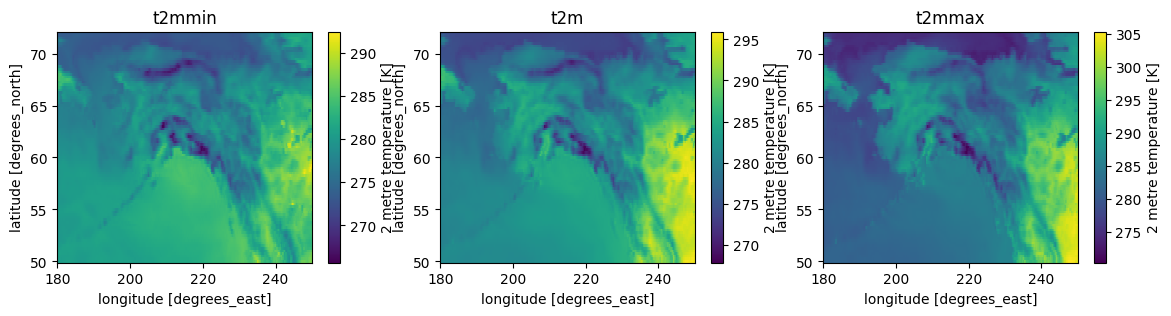

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(14, 3))

iday = np.random.randint(0, 364)
year = "1981"
sel_di = dict(longitude=slice(180, 250), latitude=slice(72, 50))

for var_id, ax in zip(["t2mmin", "t2m", "t2mmax"], axes):
    with xr.open_dataset(
        out_dir.joinpath(var_id, out_tmp_fn.format(var_id=var_id, year=year))
    ) as ds:
        ds[var_id].isel(time=iday).sel(sel_di).plot(ax=ax)
    ax.set_title(var_id)

Precip plot:

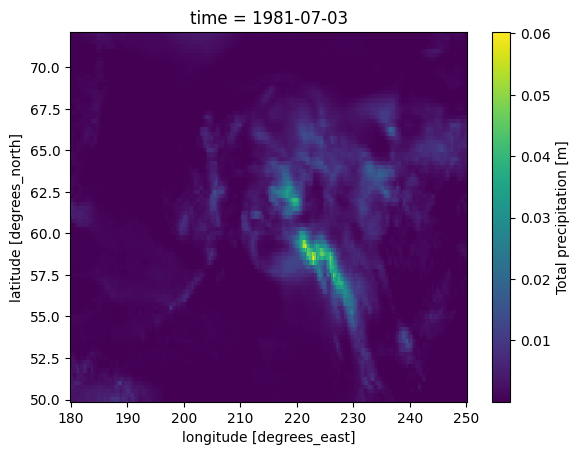

In [28]:
var_id = "tp"
with xr.open_dataset(
    out_dir.joinpath("tp", out_tmp_fn.format(var_id=var_id, year=year))
) as ds:
    ds[var_id].isel(time=iday).sel(sel_di).plot()